In [1]:
# Import image processing and OCR tools
from PIL import Image
from pytesseract import image_to_string
from pdf2image import convert_from_path
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments, DistilBertTokenizer
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from natsort import natsorted  # For naturally sorted lists (e.g., invoice1, invoice2, invoice10)

# Converts a PDF file into a list of image objects (one per page)
def pdf_to_image(pdf_file):
    return convert_from_path(pdf_file)

# Performs OCR (optical character recognition) on a single image file
def image_to_text(file):
    return image_to_string(file)

# Processes a full PDF file: converts to images → performs OCR → combines the text from all pages
def get_text_from_any_pdf(pdf_file):
    images = pdf_to_image(pdf_file)
    final_text = ""
    for pg, img in enumerate(images):
        final_text += image_to_text(img)
    return final_text

# List of PDF invoice files to be processed
pdfs = ["invoice1.pdf", "invoice2.pdf", "invoice3.pdf"]

# Load the Excel file containing ground truth invoice numbers
invoice_numbers_path = "invoices.xlsx"
df = pd.read_excel(invoice_numbers_path)

# Extract invoice numbers from the Excel file
invoice_numbers = []
for index, row in df.iterrows():
    invoice_number = row[1:].dropna().tolist()
    invoice_number = [str(num) for num in invoice_number if num is not None]
    invoice_numbers.append(invoice_number)


# Extract text from all invoice PDFs using OCR
texts = [get_text_from_any_pdf(pdf) for pdf in pdfs]


/Users/larsraufer/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/larsraufer/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[['22AR10030015'], ['AR 10609', 'AR 40225', 'AR 11277', 'AR 40357'], ['AR 29218002', 'AR 29218036'], ['608885'], ['1010308645'], ['1086035'], ['23-003866'], ['202318311'], ['202320605'], ['67309'], ['9300387492'], ['9300387789'], ['R2325765'], ['LPLIR02820255 ', 'LPLR008170995 ', 'LPLIR02831801 ', 'LPLR008193508 ', 'LPLR008216072 ', 'LPLIR02855955 ', 'LPLR008263365 ', 'LPLR008285224 '], ['0055050578', '0055050564', '0055050563', '0055050382', '0055050188', '0055050187'], ['1080054261', '1080054171', '1080054074', '1080054073', '1080054011', '1080053755', '1080053419', '1080052903', '1080052550', '1080054335'], ['SWSCC32C'], ['60117490', '60372288'], ['AR 240157000', 'GS 240615139'], ['240224', '240849'], ['23117650'], ['101101668158'], ['553245'], ['0610016262', '0610016263', '0610016264'], ['1800001412'], ['9300353194'], ['W23-32257 '], ['C00035417'], ['850000', '850465'], ['2309564'], ['1265435251', '1265436372', '1265439252', '1265439371'], ['23121827'], ['1042513', '1043269'], ['10

### Bereinigung der Daten

In [32]:
from transformers import LongformerTokenizerFast, LongformerForTokenClassification
from datasets import Dataset, DatasetDict
import torch
from sklearn.model_selection import train_test_split

# Split PDFs, invoice number labels and extracted texts into training and test sets
train_pdfs, test_pdfs, train_labels, test_labels, train_texts, test_texts = train_test_split(
    pdfs, invoice_numbers, texts, test_size=0.2, random_state=42
)

# Load Longformer tokenizer and model for token classification (e.g., NER-style)
tokenizer = LongformerTokenizerFast.from_pretrained("allenai/longformer-base-4096", add_prefix_space=True)
model = LongformerForTokenClassification.from_pretrained("allenai/longformer-base-4096", num_labels=3)
# Labels: 0 = O (outside), 1 = B (beginning of entity), 2 = I (inside of entity)

# Convert a list of tokens and known labels (e.g., invoice numbers) into NER-style tags
def label_tokens(tokens, labels):
    ner_tags = [0] * len(tokens)  # Default to "O" (no entity)
    for label in labels:
        label_parts = label.split()
        for i in range(len(tokens) - len(label_parts) + 1):
            if tokens[i:i+len(label_parts)] == label_parts:
                ner_tags[i] = 1  # "B" – beginning of the entity
                for j in range(1, len(label_parts)):
                    ner_tags[i + j] = 2  # "I" – inside the entity
                break
    return ner_tags

# Split the token sequence into overlapping segments suitable for Longformer input length
def split_into_segments(text, labels, max_length=2648, overlap=256):
    tokens = text.split()
    ner_tags = label_tokens(tokens, labels)
    segments = []
    for start_idx in range(0, len(tokens), max_length - overlap):
        end_idx = min(start_idx + max_length, len(tokens))
        segment_tokens = tokens[start_idx:end_idx]
        segment_labels = ner_tags[start_idx:end_idx]
        segments.append({"tokens": segment_tokens, "ner_tags": segment_labels})
        if end_idx == len(tokens):
            break
    return segments

# Create training segments by slicing text + labels into overlapping token windows
train_data = []
for text, labels in zip(train_texts, train_labels):
    train_data.extend(split_into_segments(text, labels))

# Do the same for the test data
test_data = []
for text, labels in zip(test_texts, test_labels):
    test_data.extend(split_into_segments(text, labels))

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

# Tokenize the input tokens and align the NER labels accordingly
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        max_length=2648,
        is_split_into_words=True,
        add_special_tokens=True
    )
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100) 
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = torch.tensor(labels)
    return tokenized_inputs

# Apply tokenization and label alignment to training and test datasets
train_tokenized = train_dataset.map(tokenize_and_align_labels, batched=True)
test_tokenized = test_dataset.map(tokenize_and_align_labels, batched=True)

# Create a DatasetDict for use in training/evaluation
dataset = DatasetDict({"train": train_tokenized, "test": test_tokenized})


Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 45/45 [00:00<00:00, 821.20 examples/s]


In [33]:
from transformers import LongformerForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import wandb

# Initialize Weights & Biases for experiment tracking
wandb.init(project="Training Plots")

# Split training dataset into training (80%) and validation (20%) sets
train_valid_split = train_dataset.train_test_split(test_size=0.2)

# Combine train, validation, and test into a single DatasetDict
dataset = DatasetDict({
    'train': train_valid_split['train'],
    'validation': train_valid_split['test'],
    'test': test_dataset
})

# Evaluation metrics for token classification (ignoring special tokens)
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored tokens (-100) from both predictions and labels
    true_labels = [[label for label in label_group if label != -100] for label_group in labels]
    true_predictions = [
        [pred for (pred, label) in zip(pred_group, label_group) if label != -100]
        for pred_group, label_group in zip(predictions, labels)
    ]
    
    # Flatten for metric calculation
    y_true = [item for sublist in true_labels for item in sublist]
    y_pred = [item for sublist in true_predictions for item in sublist]

    results = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    return {
        "accuracy": accuracy,
        "precision": results[0],
        "recall": results[1],
        "f1": results[2],
    }

# Tokenize inputs and align token-level labels with word-level annotations
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        max_length=2648,
        is_split_into_words=True,
        add_special_tokens=True
    )
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special tokens will be ignored
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # First sub-token of word gets the label
            else:
                label_ids.append(-100)  # Remaining sub-tokens are ignored
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Tokenize and align labels for each split
train_tokenized = dataset["train"].map(tokenize_and_align_labels, batched=True)
validation_tokenized = dataset["validation"].map(tokenize_and_align_labels, batched=True)
test_tokenized = dataset["test"].map(tokenize_and_align_labels, batched=True)

# Load Longformer model with 3 labels for token classification (e.g., O, B, I)
model = LongformerForTokenClassification.from_pretrained(
    "allenai/longformer-base-4096",
    num_labels=3
)

# Define training arguments for the Hugging Face Trainer
training_args = TrainingArguments(
    output_dir="./results",                 # Directory for model checkpoints
    evaluation_strategy="epoch",            # Evaluate at the end of each epoch
    logging_dir='./logs',                   # Directory for log files
    logging_steps=10,                       # Log every 10 steps
    num_train_epochs=3,                     # Number of training epochs
    per_device_train_batch_size=1,          # Batch size per device during training
    per_device_eval_batch_size=1,           # Batch size for evaluation
    save_steps=10_000,                      # Save model every 10,000 steps (not likely in small datasets)
    save_total_limit=2,                     # Keep only the 2 most recent checkpoints
    learning_rate=5e-5,                     # Learning rate for optimizer
    report_to="wandb"                       # Enable Weights & Biases logging
)

# Initialize the Hugging Face Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=validation_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Start the training loop
trainer.train()


eval/accuracy,▁▆█
eval/f1,▁▅█
eval/loss,█▁▁
eval/precision,▁▅█
eval/recall,▁▆█
eval/runtime,▁█▂
eval/samples_per_second,█▁▆
eval/steps_per_second,█▁▆
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▅▂▂▁▁▁▁▁▇▂▂▃▆█▅▂▂▄▂▂▁▂▂▁▁▁▂▁▁▃▄▁▂▁


Map: 100%|██████████| 45/45 [00:00<00:00, 891.14 examples/s]
Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/larsraufer/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  2%|▏         | 10/432 [00:12<08:34,  1.22s/it]

{'loss': 0.2715, 'grad_norm': 0.4567939043045044, 'learning_rate': 4.8842592592592595e-05, 'epoch': 0.07}


  5%|▍         | 20/432 [00:24<08:20,  1.21s/it]

{'loss': 0.0364, 'grad_norm': 0.7079790830612183, 'learning_rate': 4.768518518518519e-05, 'epoch': 0.14}


  7%|▋         | 30/432 [00:36<08:09,  1.22s/it]

{'loss': 0.0389, 'grad_norm': 0.4950207769870758, 'learning_rate': 4.652777777777778e-05, 'epoch': 0.21}


  9%|▉         | 40/432 [00:48<07:57,  1.22s/it]

{'loss': 0.0327, 'grad_norm': 1.4512842893600464, 'learning_rate': 4.5370370370370374e-05, 'epoch': 0.28}


 12%|█▏        | 50/432 [01:01<07:52,  1.24s/it]

{'loss': 0.008, 'grad_norm': 0.6532037258148193, 'learning_rate': 4.4212962962962966e-05, 'epoch': 0.35}


 14%|█▍        | 60/432 [01:13<07:43,  1.25s/it]

{'loss': 0.0111, 'grad_norm': 1.9831533432006836, 'learning_rate': 4.305555555555556e-05, 'epoch': 0.42}


 16%|█▌        | 70/432 [01:26<07:35,  1.26s/it]

{'loss': 0.0213, 'grad_norm': 1.0427509546279907, 'learning_rate': 4.1898148148148145e-05, 'epoch': 0.49}


 19%|█▊        | 80/432 [01:38<07:27,  1.27s/it]

{'loss': 0.0164, 'grad_norm': 0.8418188691139221, 'learning_rate': 4.074074074074074e-05, 'epoch': 0.56}


 21%|██        | 90/432 [01:51<07:05,  1.24s/it]

{'loss': 0.0226, 'grad_norm': 0.049703292548656464, 'learning_rate': 3.958333333333333e-05, 'epoch': 0.62}


 23%|██▎       | 100/432 [02:03<06:54,  1.25s/it]

{'loss': 0.0279, 'grad_norm': 0.2990001440048218, 'learning_rate': 3.8425925925925924e-05, 'epoch': 0.69}


 25%|██▌       | 110/432 [02:16<06:41,  1.25s/it]

{'loss': 0.0144, 'grad_norm': 2.3499555587768555, 'learning_rate': 3.726851851851852e-05, 'epoch': 0.76}


 28%|██▊       | 120/432 [02:28<06:25,  1.24s/it]

{'loss': 0.0132, 'grad_norm': 1.161244511604309, 'learning_rate': 3.611111111111111e-05, 'epoch': 0.83}


 30%|███       | 130/432 [02:40<06:10,  1.23s/it]

{'loss': 0.0089, 'grad_norm': 0.4722730815410614, 'learning_rate': 3.49537037037037e-05, 'epoch': 0.9}


 32%|███▏      | 140/432 [02:53<06:02,  1.24s/it]

{'loss': 0.0253, 'grad_norm': 1.0906095504760742, 'learning_rate': 3.3796296296296295e-05, 'epoch': 0.97}


 33%|███▎      | 144/432 [03:09<05:59,  1.25s/it]

{'eval_loss': 0.03217974305152893, 'eval_accuracy': 0.9833600641539695, 'eval_precision': 0.9872079311167995, 'eval_recall': 0.9833600641539695, 'eval_f1': 0.9848811071019052, 'eval_runtime': 10.8992, 'eval_samples_per_second': 3.395, 'eval_steps_per_second': 3.395, 'epoch': 1.0}


 35%|███▍      | 150/432 [03:17<08:47,  1.87s/it]

{'loss': 0.0096, 'grad_norm': 0.40233978629112244, 'learning_rate': 3.263888888888889e-05, 'epoch': 1.04}


 37%|███▋      | 160/432 [03:30<06:36,  1.46s/it]

{'loss': 0.0231, 'grad_norm': 0.02899923175573349, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.11}


 39%|███▉      | 170/432 [03:46<06:46,  1.55s/it]

{'loss': 0.0102, 'grad_norm': 2.4802985191345215, 'learning_rate': 3.0324074074074077e-05, 'epoch': 1.18}


 42%|████▏     | 180/432 [04:02<07:03,  1.68s/it]

{'loss': 0.012, 'grad_norm': 1.970279335975647, 'learning_rate': 2.916666666666667e-05, 'epoch': 1.25}


 44%|████▍     | 190/432 [04:21<08:07,  2.01s/it]

{'loss': 0.0042, 'grad_norm': 0.058812957257032394, 'learning_rate': 2.8009259259259263e-05, 'epoch': 1.32}


 46%|████▋     | 200/432 [04:46<10:07,  2.62s/it]

{'loss': 0.0047, 'grad_norm': 1.195839762687683, 'learning_rate': 2.6851851851851855e-05, 'epoch': 1.39}


 49%|████▊     | 210/432 [05:23<15:30,  4.19s/it]

{'loss': 0.0072, 'grad_norm': 0.3797859251499176, 'learning_rate': 2.5694444444444445e-05, 'epoch': 1.46}


 51%|█████     | 220/432 [06:20<19:29,  5.52s/it]

{'loss': 0.0174, 'grad_norm': 0.12356935441493988, 'learning_rate': 2.4537037037037038e-05, 'epoch': 1.53}


 53%|█████▎    | 230/432 [06:53<09:52,  2.93s/it]

{'loss': 0.0048, 'grad_norm': 0.06218455731868744, 'learning_rate': 2.337962962962963e-05, 'epoch': 1.6}


 56%|█████▌    | 240/432 [07:18<07:31,  2.35s/it]

{'loss': 0.0161, 'grad_norm': 0.30486559867858887, 'learning_rate': 2.2222222222222223e-05, 'epoch': 1.67}


 58%|█████▊    | 250/432 [07:39<06:21,  2.10s/it]

{'loss': 0.0114, 'grad_norm': 0.09630337357521057, 'learning_rate': 2.1064814814814816e-05, 'epoch': 1.74}


 60%|██████    | 260/432 [07:59<05:20,  1.86s/it]

{'loss': 0.0077, 'grad_norm': 1.655773401260376, 'learning_rate': 1.990740740740741e-05, 'epoch': 1.81}


 62%|██████▎   | 270/432 [08:16<04:43,  1.75s/it]

{'loss': 0.0063, 'grad_norm': 0.7347911596298218, 'learning_rate': 1.8750000000000002e-05, 'epoch': 1.88}


 65%|██████▍   | 280/432 [08:33<04:08,  1.64s/it]

{'loss': 0.022, 'grad_norm': 0.11158540844917297, 'learning_rate': 1.7592592592592595e-05, 'epoch': 1.94}


 67%|██████▋   | 288/432 [08:59<03:50,  1.60s/it]

{'eval_loss': 0.023595264181494713, 'eval_accuracy': 0.9941860465116279, 'eval_precision': 0.9940428264648217, 'eval_recall': 0.9941860465116279, 'eval_f1': 0.9941015233752724, 'eval_runtime': 13.6255, 'eval_samples_per_second': 2.715, 'eval_steps_per_second': 2.715, 'epoch': 2.0}


 67%|██████▋   | 290/432 [09:02<10:25,  4.41s/it]

{'loss': 0.0049, 'grad_norm': 0.5104025602340698, 'learning_rate': 1.6435185185185187e-05, 'epoch': 2.01}


 69%|██████▉   | 300/432 [09:17<03:25,  1.56s/it]

{'loss': 0.0006, 'grad_norm': 0.05631968379020691, 'learning_rate': 1.527777777777778e-05, 'epoch': 2.08}


 72%|███████▏  | 310/432 [09:32<03:04,  1.51s/it]

{'loss': 0.0023, 'grad_norm': 0.015363921411335468, 'learning_rate': 1.412037037037037e-05, 'epoch': 2.15}


 74%|███████▍  | 320/432 [09:46<02:37,  1.41s/it]

{'loss': 0.0057, 'grad_norm': 0.5691056251525879, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}


 76%|███████▋  | 330/432 [10:00<02:22,  1.39s/it]

{'loss': 0.003, 'grad_norm': 0.35481399297714233, 'learning_rate': 1.1805555555555555e-05, 'epoch': 2.29}


 79%|███████▊  | 340/432 [10:14<02:07,  1.38s/it]

{'loss': 0.0048, 'grad_norm': 0.013399564661085606, 'learning_rate': 1.0648148148148148e-05, 'epoch': 2.36}


 81%|████████  | 350/432 [10:28<01:50,  1.35s/it]

{'loss': 0.0087, 'grad_norm': 0.014767120592296124, 'learning_rate': 9.490740740740741e-06, 'epoch': 2.43}


 83%|████████▎ | 360/432 [10:41<01:35,  1.33s/it]

{'loss': 0.0005, 'grad_norm': 0.019239401444792747, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5}


 86%|████████▌ | 370/432 [10:54<01:22,  1.33s/it]

{'loss': 0.009, 'grad_norm': 0.07941092550754547, 'learning_rate': 7.1759259259259266e-06, 'epoch': 2.57}


 88%|████████▊ | 380/432 [11:08<01:08,  1.32s/it]

{'loss': 0.0079, 'grad_norm': 0.03159521892666817, 'learning_rate': 6.0185185185185185e-06, 'epoch': 2.64}


 90%|█████████ | 390/432 [11:21<00:55,  1.31s/it]

{'loss': 0.0007, 'grad_norm': 0.01568486914038658, 'learning_rate': 4.861111111111111e-06, 'epoch': 2.71}


 93%|█████████▎| 400/432 [11:34<00:41,  1.30s/it]

{'loss': 0.0032, 'grad_norm': 0.500495195388794, 'learning_rate': 3.7037037037037037e-06, 'epoch': 2.78}


 95%|█████████▍| 410/432 [11:47<00:28,  1.31s/it]

{'loss': 0.0005, 'grad_norm': 0.06784765422344208, 'learning_rate': 2.546296296296296e-06, 'epoch': 2.85}


 97%|█████████▋| 420/432 [12:00<00:15,  1.31s/it]

{'loss': 0.0082, 'grad_norm': 0.9436576962471008, 'learning_rate': 1.388888888888889e-06, 'epoch': 2.92}


100%|█████████▉| 430/432 [12:13<00:02,  1.31s/it]

{'loss': 0.002, 'grad_norm': 0.4477320611476898, 'learning_rate': 2.3148148148148148e-07, 'epoch': 2.99}


                                                 
100%|██████████| 432/432 [12:27<00:00,  1.73s/it]

{'eval_loss': 0.03210994973778725, 'eval_accuracy': 0.9914795509222133, 'eval_precision': 0.9908754620331887, 'eval_recall': 0.9914795509222133, 'eval_f1': 0.9905872826945578, 'eval_runtime': 11.4013, 'eval_samples_per_second': 3.245, 'eval_steps_per_second': 3.245, 'epoch': 3.0}
{'train_runtime': 747.7459, 'train_samples_per_second': 0.578, 'train_steps_per_second': 0.578, 'train_loss': 0.01776465781235688, 'epoch': 3.0}


TrainOutput(global_step=432, training_loss=0.01776465781235688, metrics={'train_runtime': 747.7459, 'train_samples_per_second': 0.578, 'train_steps_per_second': 0.578, 'total_flos': 729737038082304.0, 'train_loss': 0.01776465781235688, 'epoch': 3.0})

100%|██████████| 45/45 [00:11<00:00,  3.74it/s]/Users/larsraufer/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 45/45 [00:11<00:00,  3.81it/s]

Classification Report:
                  precision    recall  f1-score   support

               O       1.00      1.00      1.00     12453
I-invoice_number       0.86      0.94      0.90       156
B-invoice_number       0.00      0.00      0.00         2

        accuracy                           1.00     12611
       macro avg       0.62      0.65      0.63     12611
    weighted avg       1.00      1.00      1.00     12611

Evaluation Results:
Accuracy: 0.9973832368567124
Precision: 0.9973908379996194
Recall: 0.9973832368567124
F1 Score: 0.9973633166353868



/Users/larsraufer/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsraufer/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/larsraufer/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

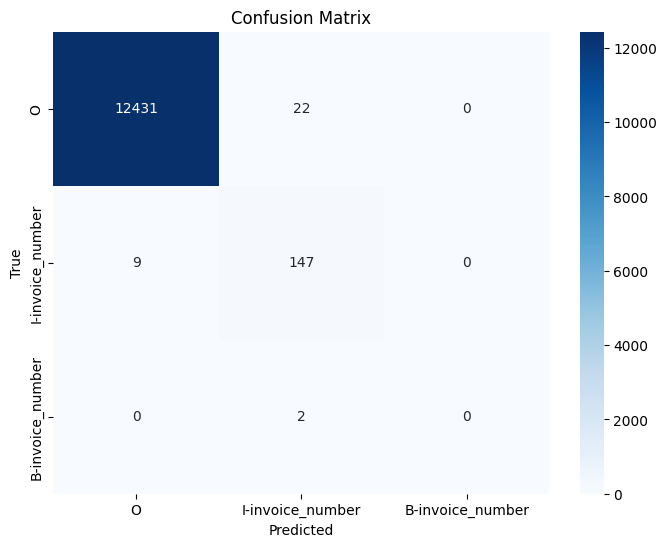

Document 0, Token 171: Predicted 0, Actual 1, Context: 67309
Document 1, Token 106: Predicted 0, Actual 1, Context: R/24003737
Document 2, Token 66: Predicted 0, Actual 1, Context: 24000298
Document 13, Token 434: Predicted 1, Actual 0, Context: 9300352905
Document 13, Token 439: Predicted 1, Actual 0, Context: 9300352906
Document 14, Token 205: Predicted 1, Actual 0, Context: 3227242-B01
Document 14, Token 218: Predicted 1, Actual 0, Context: 3219959
Document 14, Token 231: Predicted 1, Actual 0, Context: 3231613
Document 21, Token 90: Predicted 0, Actual 1, Context: AR
Document 21, Token 91: Predicted 1, Actual 2, Context: 240157000
Document 21, Token 93: Predicted 0, Actual 1, Context: GS
Document 21, Token 94: Predicted 1, Actual 2, Context: 240615139
Document 24, Token 163: Predicted 1, Actual 0, Context: 6000385159
Document 27, Token 120: Predicted 1, Actual 0, Context: 646119
Document 30, Token 175: Predicted 1, Actual 0, Context: 0091173392
Document 32, Token 4: Predicted 0, Ac

In [39]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Run evaluation on the test set using the trained model
results = trainer.predict(test_tokenized)

# Extract raw model predictions and true labels
predictions = results.predictions
labels = results.label_ids

# Convert logits to predicted class indices
predictions = np.argmax(predictions, axis=2)

# Remove special tokens (-100) from labels and predictions
true_labels = [
    [label for label in label_group if label != -100]
    for label_group in labels
]
true_predictions = [
    [pred for (pred, label) in zip(pred_group, label_group) if label != -100]
    for pred_group, label_group in zip(predictions, labels)
]

# Flatten the lists for metric calculations
true_labels_flat = [item for sublist in true_labels for item in sublist]
true_predictions_flat = [item for sublist in true_predictions for item in sublist]

# Function to compute classification metrics and confusion matrix
def compute_metrics_per_class(true_labels_flat, true_predictions_flat):
    report = classification_report(
        true_labels_flat,
        true_predictions_flat,
        target_names=["O", "I-invoice_number", "B-invoice_number"]
    )
    print("Classification Report:")
    print(report)
    
    conf_matrix = confusion_matrix(true_labels_flat, true_predictions_flat)
    return conf_matrix, report

# Compute metrics and confusion matrix
conf_matrix, report = compute_metrics_per_class(true_labels_flat, true_predictions_flat)

# Print basic metrics
print("Evaluation Results:")
print(f"Accuracy: {accuracy_score(true_labels_flat, true_predictions_flat)}")
print(f"Precision: {precision_recall_fscore_support(true_labels_flat, true_predictions_flat, average='weighted')[0]}")
print(f"Recall: {precision_recall_fscore_support(true_labels_flat, true_predictions_flat, average='weighted')[1]}")
print(f"F1 Score: {precision_recall_fscore_support(true_labels_flat, true_predictions_flat, average='weighted')[2]}")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=["O", "I-invoice_number", "B-invoice_number"],
    yticklabels=["O", "I-invoice_number", "B-invoice_number"]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Identify misclassified tokens and their surrounding context
misclassifications = []
for i, (pred, true) in enumerate(zip(true_predictions, true_labels)):
    for j, (p, t) in enumerate(zip(pred, true)):
        if p != t:
            # Extract surrounding tokens (±5) for context
            context_tokens = dataset["test"][i]['tokens'][max(0, j-5):min(len(dataset["test"][i]['tokens']), j+6)]
            context = " ".join(context_tokens)
            misclassifications.append((i, j, p, t, context))

# Print misclassified tokens with context
for doc_idx, token_idx, pred, true, context in misclassifications:
    print(
        f"Document {doc_idx}, Token {token_idx}: "
        f"Predicted {pred}, Actual {true}, "
        f"Context: {test_tokenized['tokens'][doc_idx][token_idx]}"
    )
